In [7]:
import os, textwrap, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set(style="whitegrid")
except:
    sns = None  # fallback if seaborn isn't installed

from scipy import stats
OUTDIR = "eda_outputs"
os.makedirs(OUTDIR, exist_ok=True)


In [2]:
#load the data
TRAIN_PATH = "TRAIN.csv"
TEST_PATH  = "TEST_FINAL.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()

Train shape: (188340, 10)
Test shape: (22265, 8)


,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [3]:
#structure and Missing Values
print("\nDtypes:\n", train.dtypes, "\n")
print("Missing values (train):\n", train.isna().sum(), "\n")
print("Missing values (test):\n", test.isna().sum())


Dtypes:
 ID                object
Store_id           int64
Store_Type        object
Location_Type     object
Region_Code       object
Date              object
Holiday            int64
Discount          object
#Order             int64
Sales            float64
dtype: object 

Missing values (train):
 ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64 

Missing values (test):
 ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
dtype: int64


In [4]:
#Type Fixes & Date Features
train["Date"] = pd.to_datetime(train["Date"])
test["Date"]  = pd.to_datetime(test["Date"])

cat_cols = ["Store_Type", "Location_Type", "Region_Code", "Discount"]
for c in cat_cols:
    if c in train.columns:
        train[c] = train[c].astype("category")
    if c in test.columns:
        test[c] = test[c].astype("category")

# Basic time features (handy later for TS and ML)
for df in (train, test):
    df["Year"]      = df["Date"].dt.year
    df["Month"]     = df["Date"].dt.month
    df["Week"]      = df["Date"].dt.isocalendar().week.astype(int)
    df["Day"]       = df["Date"].dt.day
    df["DayOfWeek"] = df["Date"].dt.dayofweek  # 0=Mon
    df["IsWeekend"] = (df["DayOfWeek"] >= 5).astype(int)

train[["Date","Year","Month","Week","Day","DayOfWeek","IsWeekend"]].head()

,Date,Year,Month,Week,Day,DayOfWeek,IsWeekend
0,2018-01-01,2018,1,1,1,0,0
1,2018-01-01,2018,1,1,1,0,0
2,2018-01-01,2018,1,1,1,0,0
3,2018-01-01,2018,1,1,1,0,0
4,2018-01-01,2018,1,1,1,0,0


In [5]:
#Univariate Analysis
num_cols = ["#Order", "Sales"]
train[num_cols].describe()

,#Order,Sales
count,188340.000000,188340.000000
mean,68.205692,42784.327982
std,30.467415,18456.708302
min,0.000000,0.000000
25%,48.000000,30426.000000
50%,63.000000,39678.000000
75%,82.000000,51909.000000
max,371.000000,247215.000000


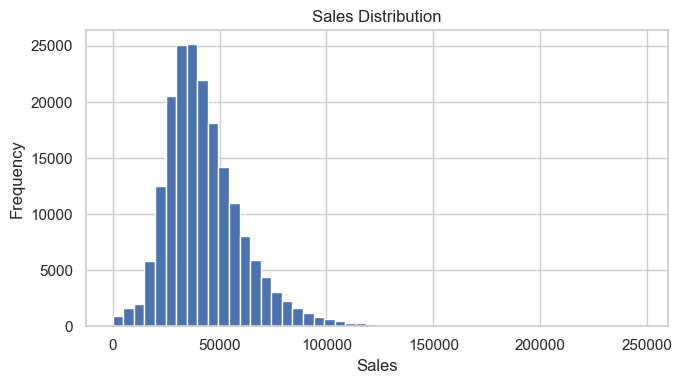

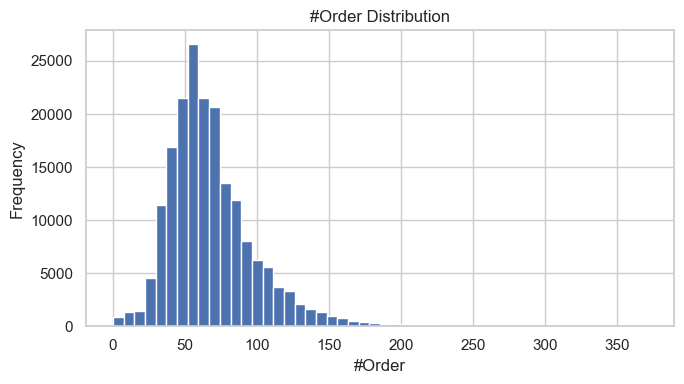

In [8]:
for col in ["Sales", "#Order"]:
    plt.figure(figsize=(7,4))
    plt.hist(train[col], bins=50)
    plt.title(f"{col} Distribution")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(f"{OUTDIR}/{col}_hist.png", dpi=150)
    plt.show()

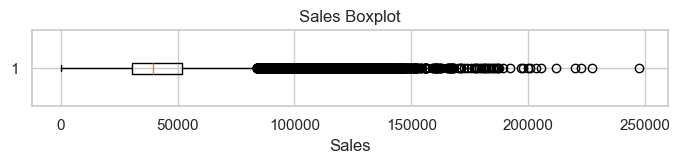

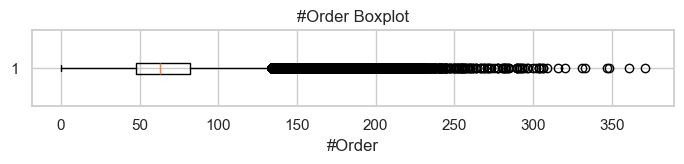

In [9]:
for col in ["Sales", "#Order"]:
    plt.figure(figsize=(7,1.8))
    plt.boxplot(train[col].dropna(), vert=False, whis=1.5)
    plt.title(f"{col} Boxplot")
    plt.xlabel(col)
    plt.tight_layout()
    plt.savefig(f"{OUTDIR}/{col}_box.png", dpi=150)
    plt.show()

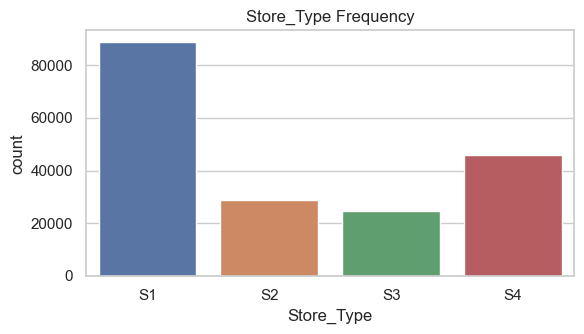

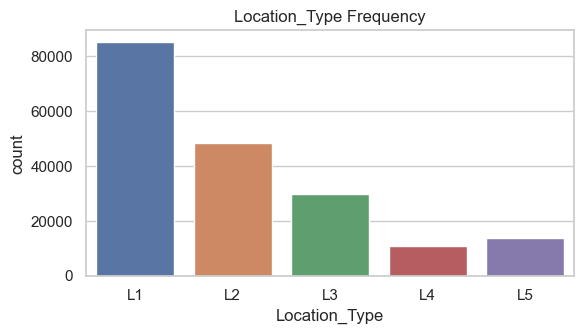

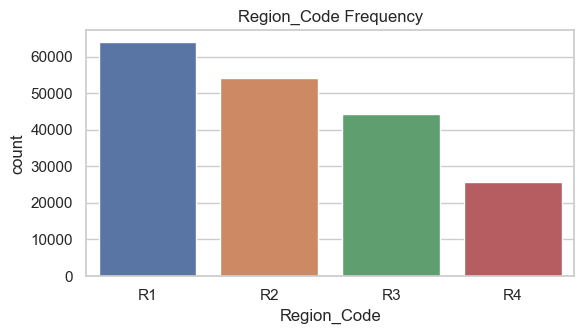

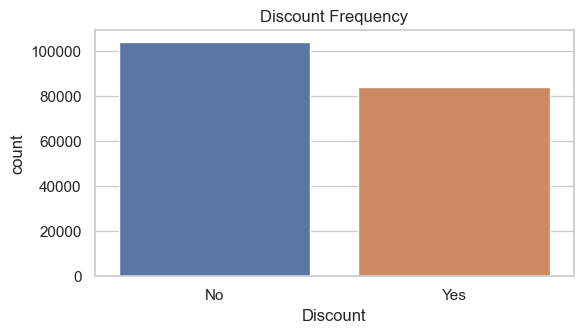

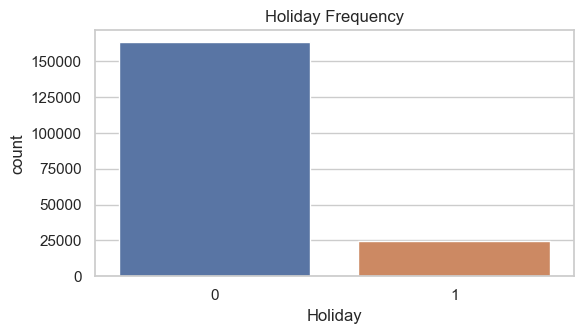

In [10]:
cat_to_plot = ["Store_Type", "Location_Type", "Region_Code", "Discount", "Holiday"]
for c in cat_to_plot:
    if c not in train.columns: 
        continue
    plt.figure(figsize=(6,3.5))
    if sns is not None:
        sns.countplot(x=c, data=train)
    else:
        train[c].value_counts().plot(kind="bar")
    plt.title(f"{c} Frequency")
    plt.tight_layout()
    plt.savefig(f"{OUTDIR}/{c}_count.png", dpi=150)
    plt.show()

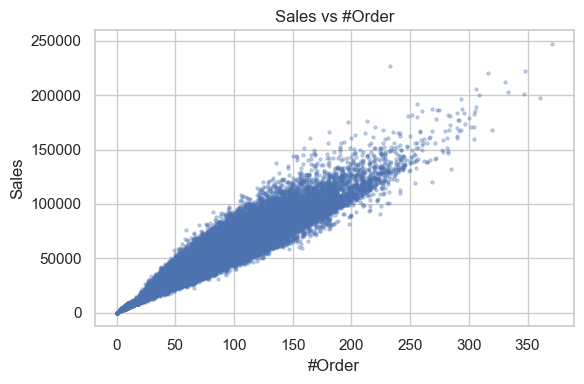

Pearson r=0.942, p=0
Spearman r=0.938, p=0


In [11]:
#Bivariate Analysis
plt.figure(figsize=(6,4))
plt.scatter(train["#Order"], train["Sales"], s=5, alpha=0.3)
plt.title("Sales vs #Order")
plt.xlabel("#Order"); plt.ylabel("Sales")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/sales_vs_orders_scatter.png", dpi=150)
plt.show()

pearson_r, pearson_p = stats.pearsonr(train["#Order"], train["Sales"])
spearman_r, spearman_p = stats.spearmanr(train["#Order"], train["Sales"])
print(f"Pearson r={pearson_r:.3f}, p={pearson_p:.3g}")
print(f"Spearman r={spearman_r:.3f}, p={spearman_p:.3g}")

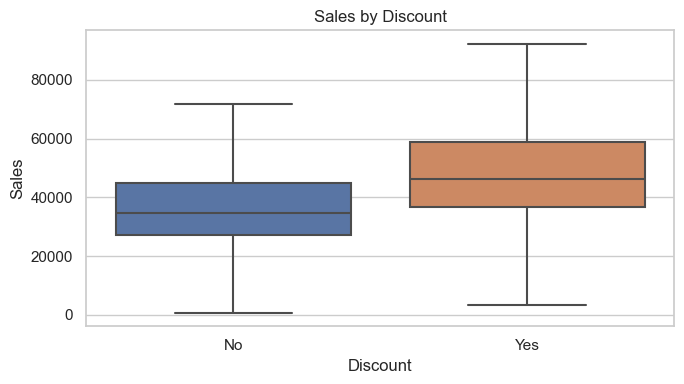

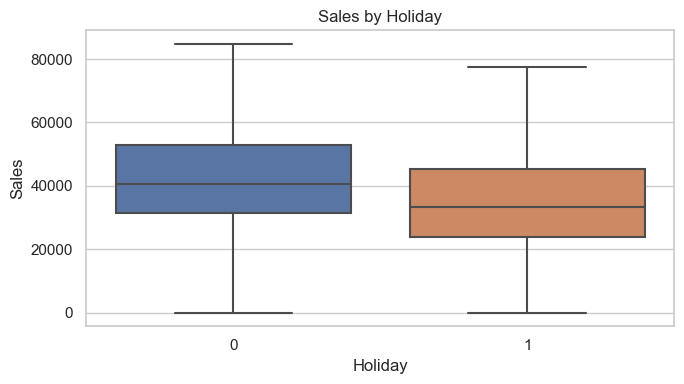

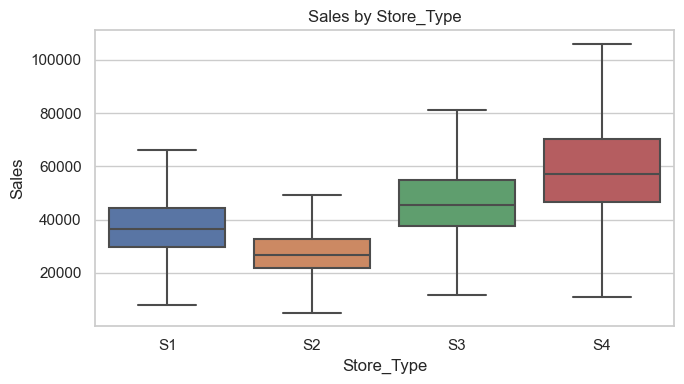

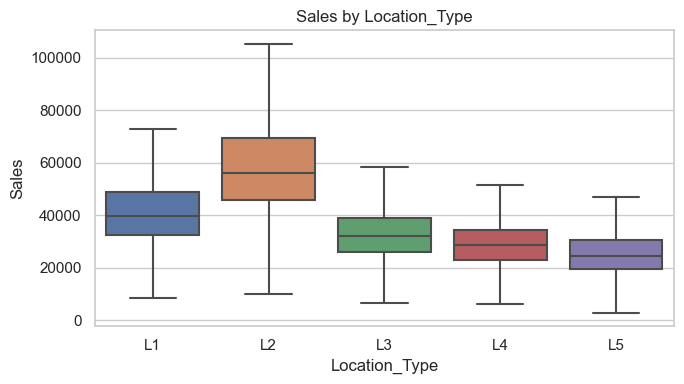

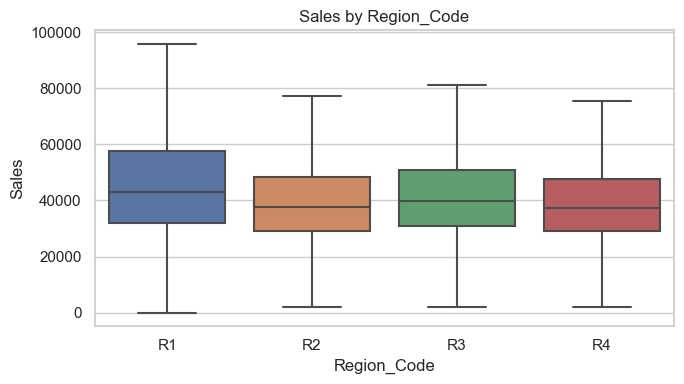

In [12]:
def box_by(feature):
    plt.figure(figsize=(7,4))
    if sns is not None:
        sns.boxplot(x=feature, y="Sales", data=train, showfliers=False)
    else:
        # fallback: median bars
        train.groupby(feature)["Sales"].median().plot(kind="bar")
        plt.ylabel("Median Sales")
    plt.title(f"Sales by {feature}")
    plt.tight_layout()
    plt.savefig(f"{OUTDIR}/sales_by_{feature}.png", dpi=150)
    plt.show()

for feat in ["Discount", "Holiday", "Store_Type", "Location_Type", "Region_Code"]:
    if feat in train.columns:
        box_by(feat)

In [13]:
group_cols = [
    ["Discount"], ["Holiday"], ["Store_Type"], ["Location_Type"], ["Region_Code"],
    ["Year","Month"]
]

tables = {}
for cols in group_cols:
    tbl = (train
           .groupby(cols, as_index=False)
           .agg(avg_sales=("Sales","mean"),
                med_sales=("Sales","median"),
                avg_orders=("#Order","mean"),
                n=("ID","count")))
    tables[tuple(cols)] = tbl.sort_values("avg_sales", ascending=False).head(10)
    display(tbl.head(10))

,Discount,avg_sales,med_sales,avg_orders,n
0,No,37403.679678,34791.0,61.806153,104051
1,Yes,49426.497620,46242.0,76.105637,84289


,Holiday,avg_sales,med_sales,avg_orders,n
0,0,43897.288998,40530.00,69.873379,163520
1,1,35451.878930,33417.54,57.218574,24820


,Store_Type,avg_sales,med_sales,avg_orders,n
0,S1,37676.511694,36444.0,58.022095,88752
1,S2,27530.828222,26794.5,40.472799,28896
2,S3,47063.068209,45445.5,73.663396,24768
3,S4,59945.685926,57075.0,102.392779,45924


,Location_Type,avg_sales,med_sales,avg_orders,n
0,L1,41453.597889,39831.000,65.265938,85140
1,L2,59231.480373,56235.975,94.851456,48504
2,L3,33072.257756,31987.200,53.156943,29928
3,L4,29067.414313,28554.000,47.386028,10836
4,L5,25187.787261,24528.000,41.924131,13932


,Region_Code,avg_sales,med_sales,avg_orders,n
0,R1,46765.488405,43125.0,79.626063,63984
1,R2,40054.847344,37548.0,62.798616,54180
2,R3,42144.517063,39661.5,63.882436,44376
3,R4,39743.434249,37474.5,58.674031,25800


,Year,Month,avg_sales,med_sales,avg_orders,n
0,2018,1,44778.244619,41976.00,65.373133,11315
1,2018,2,40859.981422,38199.00,67.297260,10220
2,2018,3,41697.499485,39390.00,68.371365,11315
3,2018,4,41328.451847,37971.00,68.115342,10950
4,2018,5,45756.985029,42957.00,67.517897,11315
5,2018,6,44705.726389,41283.00,66.174155,10950
6,2018,7,46585.406232,42267.00,76.048873,11315
7,2018,8,40020.368869,37663.74,67.128502,11315
8,2018,9,41123.184822,38202.00,68.509954,10950
9,2018,10,38988.407398,36294.00,65.460009,11315


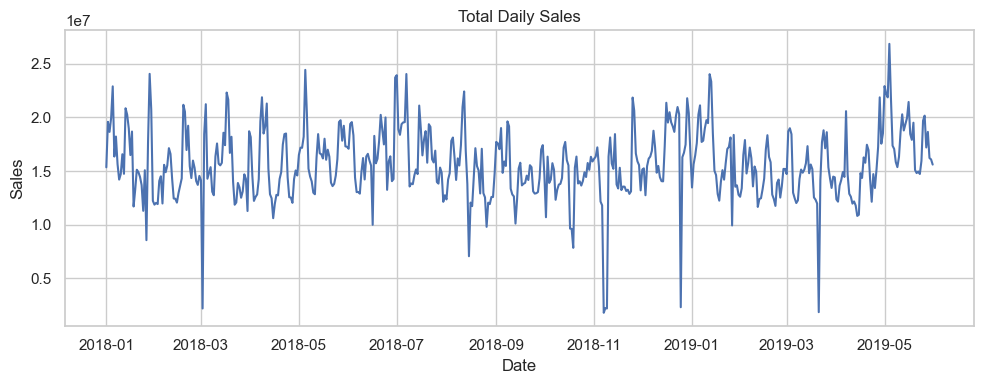

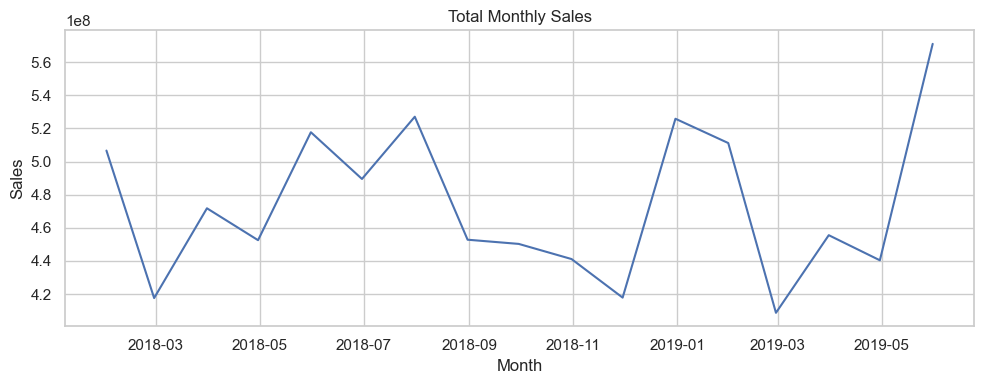

In [14]:
#TimeSeries Analysis
daily = train.groupby("Date", as_index=True).agg(total_sales=("Sales","sum"),
                                                 total_orders=("#Order","sum"))
monthly = daily.resample("M").sum()

fig = plt.figure(figsize=(10,4))
plt.plot(daily.index, daily["total_sales"])
plt.title("Total Daily Sales")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/daily_total_sales.png", dpi=150)
plt.show()

fig = plt.figure(figsize=(10,4))
plt.plot(monthly.index, monthly["total_sales"])
plt.title("Total Monthly Sales")
plt.xlabel("Month"); plt.ylabel("Sales")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/monthly_total_sales.png", dpi=150)
plt.show()

In [15]:
#Outlier Detection (IQR Method)
def iqr_outlier_mask(s):
    q1, q3 = np.percentile(s.dropna(), [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (s < lower) | (s > upper), (lower, upper)

out_sales_mask, (sl, su) = iqr_outlier_mask(train["Sales"])
out_order_mask, (ol, ou) = iqr_outlier_mask(train["#Order"])

print(f"Sales outliers: {out_sales_mask.sum()} rows  | bounds=({sl:,.0f}, {su:,.0f})")
print(f"#Order outliers: {out_order_mask.sum()} rows | bounds=({ol:,.0f}, {ou:,.0f})")

# Optional filtered dataset (keep for modeling later if you decide to trim)
train_filtered = train[~(out_sales_mask | out_order_mask)].copy()
print("Filtered shape:", train_filtered.shape)

Sales outliers: 5843 rows  | bounds=(-1,798, 84,134)
#Order outliers: 7089 rows | bounds=(-3, 133)
Filtered shape: (179918, 16)


In [16]:
#Hypothesis Testing 
def cohens_d(x, y):
    x, y = pd.Series(x).dropna(), pd.Series(y).dropna()
    nx, ny = len(x), len(y)
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    pooled = ((nx-1)*vx + (ny-1)*vy) / (nx+ny-2)
    return (x.mean() - y.mean()) / np.sqrt(pooled)

def eta_squared_from_anova(F, k, N):
    # k = number of groups, N = total observations
    return (F * (k - 1)) / (F * (k - 1) + (N - k))

In [17]:
yes = train.loc[train["Discount"] == "Yes", "Sales"]
no  = train.loc[train["Discount"] == "No",  "Sales"]
t_disc, p_disc = stats.ttest_ind(yes, no, equal_var=False)
d_disc = cohens_d(yes, no)

print(f"Discount impact (Welch t-test): t={t_disc:.2f}, p={p_disc:.3g}, Cohen's d={d_disc:.2f}")
print(f"Means: Yes={yes.mean():,.0f}, No={no.mean():,.0f}")

Discount impact (Welch t-test): t=145.93, p=0, Cohen's d=0.69
Means: Yes=49,426, No=37,404


In [18]:
h1 = train.loc[train["Holiday"] == 1, "Sales"]
h0 = train.loc[train["Holiday"] == 0, "Sales"]
t_hol, p_hol = stats.ttest_ind(h1, h0, equal_var=False)
d_hol = cohens_d(h1, h0)

print(f"Holiday impact (Welch t-test): t={t_hol:.2f}, p={p_hol:.3g}, Cohen's d={d_hol:.2f}")
print(f"Means: Holiday={h1.mean():,.0f}, Non-holiday={h0.mean():,.0f}")

Holiday impact (Welch t-test): t=-66.18, p=0, Cohen's d=-0.46
Means: Holiday=35,452, Non-holiday=43,897


In [19]:
groups_store = [g["Sales"].values for _, g in train.groupby("Store_Type")]
anova_store = stats.f_oneway(*groups_store)
k_store     = stats.kruskal(*groups_store)

k = train["Store_Type"].nunique()
N = train.shape[0]
eta2_store = eta_squared_from_anova(anova_store.statistic, k, N)

print(f"Store Type ANOVA: F={anova_store.statistic:.2f}, p={anova_store.pvalue:.3g}, eta²={eta2_store:.3f}")
print(f"Store Type Kruskal-Wallis (nonparam): H={k_store.statistic:.2f}, p={k_store.pvalue:.3g}")

Store Type ANOVA: F=35123.64, p=0, eta²=0.359
Store Type Kruskal-Wallis (nonparam): H=73677.06, p=0


In [20]:
groups_reg = [g["Sales"].values for _, g in train.groupby("Region_Code")]
anova_reg = stats.f_oneway(*groups_reg)
k_reg     = stats.kruskal(*groups_reg)

k = train["Region_Code"].nunique()
N = train.shape[0]
eta2_reg = eta_squared_from_anova(anova_reg.statistic, k, N)

print(f"Region ANOVA: F={anova_reg.statistic:.2f}, p={anova_reg.pvalue:.3g}, eta²={eta2_reg:.3f}")
print(f"Region Kruskal-Wallis: H={k_reg.statistic:.2f}, p={k_reg.pvalue:.3g}")

Region ANOVA: F=1682.43, p=0, eta²=0.026
Region Kruskal-Wallis: H=3968.06, p=0


In [21]:
pearson_r, pearson_p = stats.pearsonr(train["#Order"], train["Sales"])
spearman_r, spearman_p = stats.spearmanr(train["#Order"], train["Sales"])
print(f"Pearson r={pearson_r:.3f}, p={pearson_p:.3g}")
print(f"Spearman r={spearman_r:.3f}, p={spearman_p:.3g}")

Pearson r=0.942, p=0
Spearman r=0.938, p=0


In [22]:
results = pd.DataFrame({
    "Test": [
        "Discount -> Sales (Welch t-test)",
        "Holiday -> Sales (Welch t-test)",
        "Store Type -> Sales (ANOVA)",
        "Region -> Sales (ANOVA)",
        "Orders-Sales (Pearson)",
        "Orders-Sales (Spearman)"
    ],
    "Statistic": [
        t_disc, t_hol, anova_store.statistic, anova_reg.statistic, pearson_r, spearman_r
    ],
    "p_value": [
        p_disc, p_hol, anova_store.pvalue, anova_reg.pvalue, pearson_p, spearman_p
    ],
    "Effect_Size": [
        d_disc, d_hol, eta2_store, eta2_reg, np.nan, np.nan
    ]
})
results.to_csv(f"{OUTDIR}/hypothesis_results.csv", index=False)
results

,Test,Statistic,p_value,Effect_Size
0,Discount -> Sales (Welch t-test),145.929462,0.0,0.688524
1,Holiday -> Sales (Welch t-test),-66.175765,0.0,-0.463160
2,Store Type -> Sales (ANOVA),35123.644116,0.0,0.358762
3,Region -> Sales (ANOVA),1682.425529,0.0,0.026100
4,Orders-Sales (Pearson),0.941601,0.0,NaN
5,Orders-Sales (Spearman),0.937746,0.0,NaN
